# Mumbai Property Price Prediction Model:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Establishing connection with the database

In [ ]:
conn = sqlite3.connect('real_estate.db')
print(conn)

df = pd.read_sql_query("select * from properties",conn)
print(df.shape)
df.head(3)

Rows and columns
(60960, 11)


,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price
0,New Property,Unfurnished,2,761,2,2,Aug '29,Kandivali West,19.207751,72.846389,21800000.0
1,New Property,Unfurnished,2,684,2,NaN,Dec '27,Sion,19.052807,72.872584,21400000.0
2,New Property,Semi-Furnished,1,440,2,NaN,Dec '26,Navghar Road,19.304890,72.866211,8156093.0
3,New Property,Unfurnished,1,380,1,NaN,Dec '27,Chembur,19.064140,72.899629,9690000.0
4,New Property,Unfurnished,2,950,2,NaN,Ready to Move,Kandivali West,19.212644,72.832016,22252500.0


In [92]:
df.describe()

,latitude,longitude,price
count,60960.000000,60960.000000,6.080200e+04
mean,18.142453,69.345653,3.291852e+07
std,4.168328,15.768332,4.968846e+07
min,0.000000,0.000000,1.000000e+05
25%,19.062055,72.836888,1.919300e+07
50%,19.141193,72.863441,2.758600e+07
75%,19.205002,72.915620,3.720000e+07
max,22.445813,88.397428,9.680000e+09


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60960 entries, 0 to 60959
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_type   60950 non-null  object 
 1   furnish_status  60591 non-null  object 
 2   bedrooms        60960 non-null  object 
 3   carpet_area     60960 non-null  object 
 4   bathrooms       60775 non-null  object 
 5   balconies       31965 non-null  object 
 6   poss_status     60689 non-null  object 
 7   location        60540 non-null  object 
 8   latitude        60960 non-null  float64
 9   longitude       60960 non-null  float64
 10  price           60802 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.1+ MB


# Data Cleaning and EDA:


#### Fixing datatype mismatch :

In [94]:
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce').astype('Int64')
df['carpet_area'] = pd.to_numeric(df['carpet_area'], errors='coerce').astype('Int64')
df['balconies'] = pd.to_numeric(df['balconies'], errors='coerce').astype('Int64')
df['price'] = pd.to_numeric(df['price'], errors='coerce').astype('Int64')
df['bathrooms'] = pd.to_numeric(df['bathrooms'],errors='coerce').astype('Int64')

print(df.dtypes)

property_type      object
furnish_status     object
bedrooms            Int64
carpet_area         Int64
bathrooms           Int64
balconies           Int64
poss_status        object
location           object
latitude          float64
longitude         float64
price               Int64
dtype: object


### Imputing and Fixing Null Values:

In [95]:
print("Null values in the dataset")
print(df.isna().sum())

Null values in the dataset
property_type        10
furnish_status      369
bedrooms             66
carpet_area         238
bathrooms           202
balconies         29015
poss_status         271
location            420
latitude              0
longitude             0
price               158
dtype: int64


In [96]:
df['balconies'].fillna(0,inplace=True)
print(df.isna().sum())

property_type      10
furnish_status    369
bedrooms           66
carpet_area       238
bathrooms         202
balconies           0
poss_status       271
location          420
latitude            0
longitude           0
price             158
dtype: int64


In [97]:
df['bedrooms'].fillna(0,inplace=True)
print(df.isna().sum())

property_type      10
furnish_status    369
bedrooms            0
carpet_area       238
bathrooms         202
balconies           0
poss_status       271
location          420
latitude            0
longitude           0
price             158
dtype: int64


In [98]:
df.dropna(subset=['price'], inplace=True)
print(df.isna().sum())

property_type       1
furnish_status    265
bedrooms            0
carpet_area       165
bathrooms         101
balconies           0
poss_status       167
location          402
latitude            0
longitude           0
price               0
dtype: int64


In [99]:
df.dropna(inplace=True)
print(df.shape)
print(df.isna().sum())

(59866, 11)
property_type     0
furnish_status    0
bedrooms          0
carpet_area       0
bathrooms         0
balconies         0
poss_status       0
location          0
latitude          0
longitude         0
price             0
dtype: int64


In [100]:
df.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price
0,New Property,Unfurnished,2,761,2,2,Aug '29,Kandivali West,19.207751,72.846389,21800000
1,New Property,Unfurnished,2,684,2,0,Dec '27,Sion,19.052807,72.872584,21400000
2,New Property,Semi-Furnished,1,440,2,0,Dec '26,Navghar Road,19.304890,72.866211,8156093


### Modifying Column Values:

In [101]:
categorical_cols = df.select_dtypes(exclude=['Int64','float64']).columns
categorical_cols

Index(['property_type', 'furnish_status', 'poss_status', 'location'], dtype='object')

In [102]:
for col in categorical_cols:
    print(df[col].nunique())
    print(df[col].unique())

4
['New Property' 'Resale' 'Other' 'Rent']
3
['Unfurnished' 'Semi-Furnished' 'Furnished']
34
["Aug '29" "Dec '27" "Dec '26" 'Ready to Move' "Oct '29" "Jun '30"
 "Sep '30" "Dec '30" "Aug '28" "Jun '27" "Dec '28" "Dec '29" "Jan '28"
 "Jun '25" "Mar '31" "May '25" "Mar '27" "Mar '29" 'Ready To Move'
 "Sep '28" "Dec '25" "Oct '27" "Nov '27" "Oct '31" "Mar '28"
 'Under Construction' "Mar '26" "Mar '32" "Jun '31" "Jul '28" "May '28"
 'Ongoing' 'Immediately' "Jun '26"]
698
['Kandivali West' 'Sion' 'Navghar Road' 'Chembur' 'Borivali East'
 'Mulund West' 'Bandra East' 'Andheri West' 'Kanjurmarg East' 'Dindoshi'
 'Juhu' 'Wadala' 'Powai' 'Malad West' 'Bhandup West' 'Kandivali East'
 'Borivali West' 'Tardeo' 'Mulund East' 'Malad East' 'Mira Road East'
 'Lower Parel West' 'Bandra West' 'Parel' 'Sewri' 'Worli' 'Goregaon West'
 'Vile Parle East' 'Lal Baug' 'Bandra Kurla Complex' 'Kurla' 'Borivali'
 'Nahur East' 'Matunga East' 'Lower Parel' 'Byculla' 'Mahalakshmi'
 'Vikhroli West' 'Vasai West' 'Bycull

In [103]:
# Changed other to resale, and removed rows with rent.

df['property_type'].replace({'Other':'Resale'},inplace=True)
df = df.query('property_type != "Rent"')
df['property_type'].unique()

array(['New Property', 'Resale'], dtype=object)

In [104]:
# Modifying values in poss_status: converting all month rows data with 'Under Construction'
print("Unique values in poss_status column",df['poss_status'].unique())

df['poss_status'] = df['poss_status'].apply(lambda x: x if x in ['Under Construction', 'Immediately', 'Ongoing', 'Ready To Move','Ready to Move'] else 'Under Construction')
df['poss_status'].replace({'Ready To Move':'Ready to Move','Ongoing':'Under Construction'},inplace=True)
print("Unique values after fixing ",df['poss_status'].unique())

Unique values in poss_status column ["Aug '29" "Dec '27" "Dec '26" 'Ready to Move' "Oct '29" "Jun '30"
 "Sep '30" "Dec '30" "Aug '28" "Jun '27" "Dec '28" "Dec '29" "Jan '28"
 "Jun '25" "Mar '31" "May '25" "Mar '27" "Mar '29" 'Ready To Move'
 "Sep '28" "Dec '25" "Oct '27" "Nov '27" "Oct '31" "Mar '28"
 'Under Construction' "Mar '26" "Mar '32" "Jun '31" "Jul '28" "May '28"
 'Ongoing' "Jun '26"]
Unique values after fixing  ['Under Construction' 'Ready to Move']


In [105]:
# Fixing values in poss_staus based on domain knowledge: A property cannot both be resale and under construction.
print(df.query('property_type =="Resale" & poss_status == "Under Construction"').shape)

df.loc[(df['property_type'] == 'Resale') & (df['poss_status'] == 'Under Construction'), 'poss_status'] = 'Ready to Move'
print(df.query('property_type =="Resale" & poss_status == "Under Construction"').shape)

(245, 11)
(0, 11)


In [106]:
numeric_cols = df.select_dtypes(exclude='object').columns
numeric_cols

Index(['bedrooms', 'carpet_area', 'bathrooms', 'balconies', 'latitude',
       'longitude', 'price'],
      dtype='object')

In [107]:
# Recheking the applied transformation on categorical column.
for col in categorical_cols.drop('location'):
    print(df[col].unique())

['New Property' 'Resale']
['Unfurnished' 'Semi-Furnished' 'Furnished']
['Under Construction' 'Ready to Move']


In [108]:
for col in numeric_cols:
    print(df[col].nunique())

9
1101
10
9
2337
2305
880


### Handling outliers based on domain knowledge:

In [109]:
df.describe()

,bedrooms,carpet_area,bathrooms,balconies,latitude,longitude,price
count,59863.0,59863.0,59863.0,59863.0,59863.000000,59863.000000,59863.0
mean,2.439153,994.262533,2.515961,0.726759,18.412869,70.380300,32889106.236373
std,0.777706,2221.525636,0.739007,0.800646,3.556939,13.399500,27178424.663418
min,1.0,1.0,1.0,0.0,0.000000,0.000000,140000.0
25%,2.0,745.0,2.0,0.0,19.064140,72.839198,20700000.0
50%,3.0,902.0,3.0,1.0,19.148583,72.866211,27618000.0
75%,3.0,1170.0,3.0,1.0,19.205002,72.915620,40000000.0
max,10.0,300000.0,10.0,9.0,22.445813,88.397428,2001000000.0


### Univariate analysis: Box plots for outliers

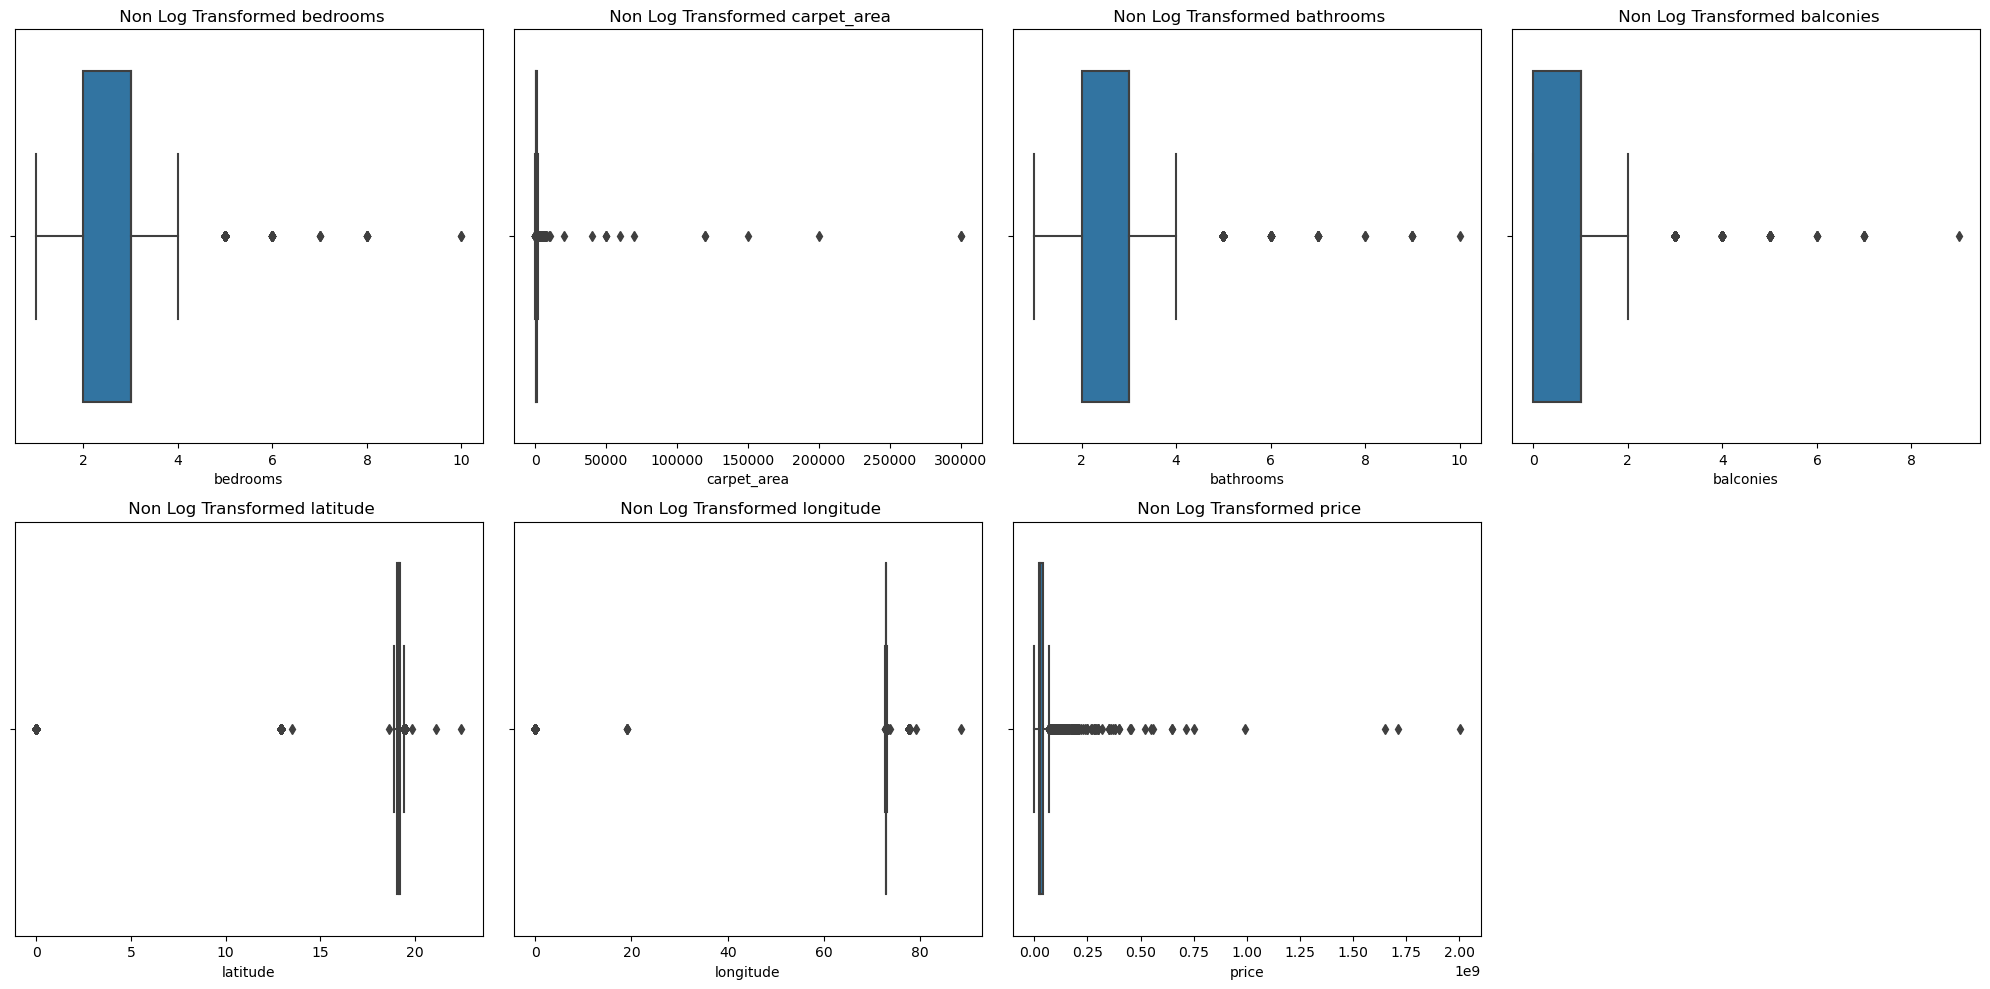

In [111]:
num_plots = len(numeric_cols)
rows = (num_plots // 4) + (num_plots % 4 > 0) 
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten() 

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f' Non Log Transformed {col}')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Fixing outliers in bedrooms column:

In [112]:
df['bedrooms'].describe()

count     59863.0
mean     2.439153
std      0.777706
min           1.0
25%           2.0
50%           3.0
75%           3.0
max          10.0
Name: bedrooms, dtype: Float64

In [113]:
print(df.query('bedrooms > 5').shape)
df.query('bedrooms > 5')[['bedrooms','carpet_area','bathrooms']].head(5)

(39, 11)


,bedrooms,carpet_area,bathrooms
62,6,2194,2
140,6,3900,8
264,6,2160,6
360,7,5650,6
415,6,2500,6


In [114]:
# Removing bedrooms greater than 5.
print(df.shape)
df = df.query('bedrooms <= 5 ')


(59863, 11)


#### Outlier treatment in carpet area column:

In [115]:
# Outlier treatment in carpet area:
df['carpet_area'].describe()

count        59824.0
mean      979.280423
std      1490.513928
min              1.0
25%            745.0
50%            902.0
75%           1170.0
max         300000.0
Name: carpet_area, dtype: Float64

In [116]:
# We will drop carpet_area less than 140 Sqft.
print("Rows with carpet area less than 140sqft: ",df.query('carpet_area < 140').shape)

df = df.query('carpet_area >= 140')
print(df.query('carpet_area < 140').shape)

print(df.shape)

Rows with carpet area less than 140sqft:  (18, 11)
(0, 11)
(59806, 11)


In [117]:
# We will drop rows where carpet_area has no relation wit bedrooms.
print(df.query('carpet_area < 745  & bedrooms > 2').shape)

df.query("not (carpet_area < 745 and bedrooms > 2)", inplace=True)
print(df.shape)

(16, 11)
(59790, 11)


In [118]:
# Dropping rows where carpet_area doesnt align with no of bedrooms:
print(df.query('carpet_area > 1561 & bedrooms < 3').shape)

df = df.query('not (carpet_area > 1561 & bedrooms < 3)')
print(df.shape)

(14, 11)
(59776, 11)


#### Outlier treatment in balconies column:

In [119]:
# Dropping outliers in balconies: Maintaining balance between noof balconies and bedrooms.

print(df.query('balconies > 5 & bedrooms < 5 ').shape)
print(df.query('balconies > 3 & bedrooms < 2 ').shape)
print(df.query('balconies > 4 & bedrooms < 3 ').shape)

(6, 11)
(3, 11)
(6, 11)


In [120]:
df = df.drop(df.query('(balconies > 5 & bedrooms < 5) | (balconies > 3 & bedrooms < 2) | (balconies > 4 & bedrooms < 3)').index)
print(df.shape)

(59762, 11)


#### Outlier treatment in location column:

In [123]:
df['location'].nunique()

688

In [ ]:
# There are total 285 improper locations with value 1: We will remove those location rows 
print(df['location'].value_counts().sort_values(ascending=True).head(3))
print("Rows with location value count 1 = ",(df['location'].value_counts() == 1).sum())
print("Rows with location value count more than 1 = ",(df['location'].value_counts() > 1).sum())

Rows with location value count 1 =  285
Rows with location value count more than 1 =  403


In [126]:
df = df[df['location'].map(df['location'].value_counts()) > 1]
print(df.shape)
print("Location count after cleaning ",df['location'].nunique())

(59477, 11)
Location count after cleaning  403


#### Outlier treatment in bathrooms column:

Removing Bathrooms more than 5

In [127]:
df['bathrooms'].describe()

count     59477.0
mean     2.516653
std      0.730552
min           1.0
25%           2.0
50%           3.0
75%           3.0
max           9.0
Name: bathrooms, dtype: Float64

In [128]:
print(df.query('bathrooms > 5').shape)
df = df.query('bathrooms <= 6')

print(df['bathrooms'].unique())

(18, 11)
<IntegerArray>
[2, 1, 3, 4, 5, 6]
Length: 6, dtype: Int64


### Outlier treatment price column:

In [129]:
df['price'].describe()

count            59473.0
mean     32826712.212752
std      26277158.073407
min             250000.0
25%           20700000.0
50%           27618000.0
75%           40000000.0
max         2001000000.0
Name: price, dtype: Float64

In [130]:
print(df['price'].quantile(0.75))
print(df['price'].quantile(0.80))

df[df['price'] > df['price'].quantile(0.95)].shape


40000000.0
41550000.0


(2328, 11)

In [131]:
print(df.query('price > 150000000 ').shape)
print(df.query('price <= 150000000').shape)

(394, 11)
(59079, 11)


In [132]:
# Removed rows where price is above 15 crore but kept the juhu proeprties:
df = df.query('price <= 150000000 | location == "Juhu"')
print(df.shape)

(59164, 11)


## Univariate analysis:


### Histogram's for analyzing Distribution

In [133]:
numeric_cols

Index(['bedrooms', 'carpet_area', 'bathrooms', 'balconies', 'latitude',
       'longitude', 'price'],
      dtype='object')

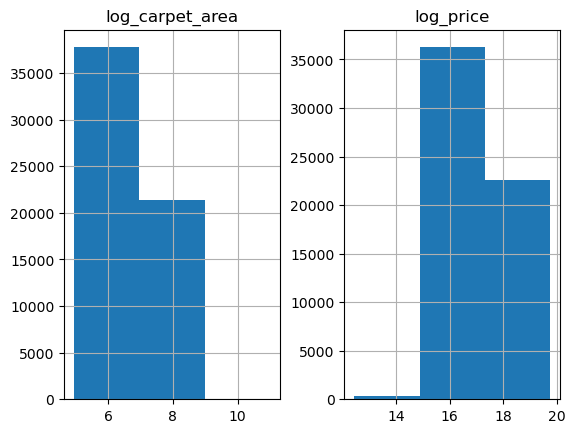

In [134]:
df['log_carpet_area'] = np.log(df['carpet_area'])
df['log_price'] = np.log(df['price'])

df[['log_carpet_area', 'log_price']].hist(bins=3)
plt.show()

In [136]:
df.head(2)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price,log_carpet_area,log_price
0,New Property,Unfurnished,2,761,2,2,Under Construction,Kandivali West,19.207751,72.846389,21800000,6.634633,16.897421
1,New Property,Unfurnished,2,684,2,0,Under Construction,Sion,19.052807,72.872584,21400000,6.527958,16.878901


### Bivariate analysis: Categorical features

In [137]:
categorical_cols

Index(['property_type', 'furnish_status', 'poss_status', 'location'], dtype='object')

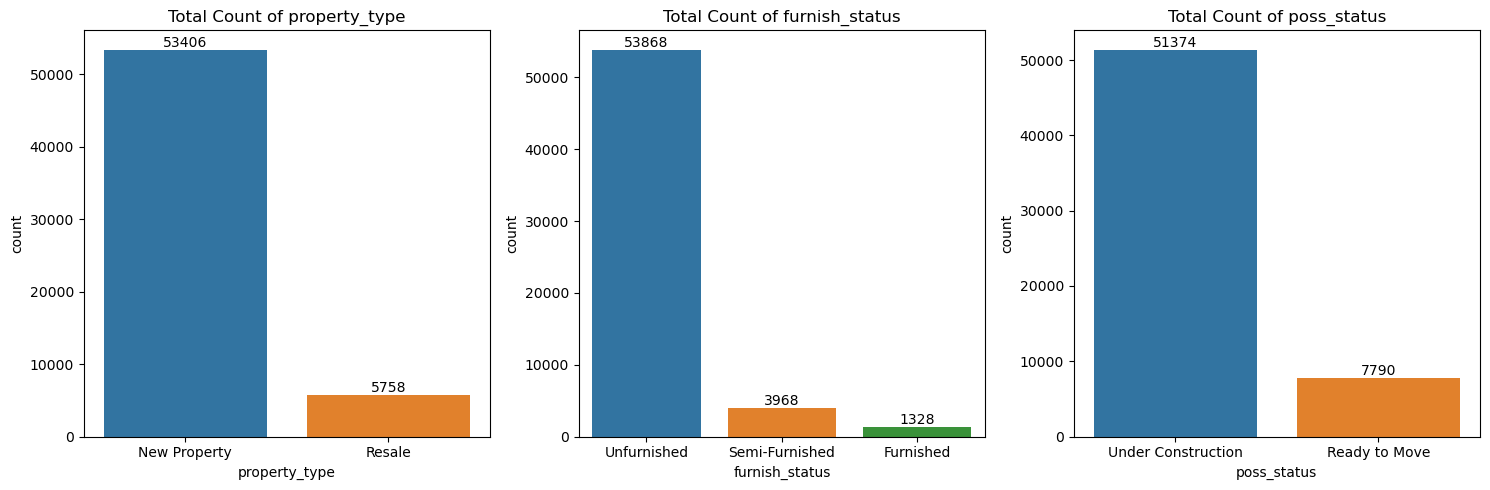

In [138]:
cols = categorical_cols.drop('location')

# Create subplots (1 row, multiple columns)
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 5))

for col, ax in zip(cols, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f"Total Count of {col}")
    ax.bar_label(ax.containers[0])

plt.tight_layout() 
plt.show()

<Axes: title={'center': 'Top 10 Locality by highest average price'}, ylabel='location'>

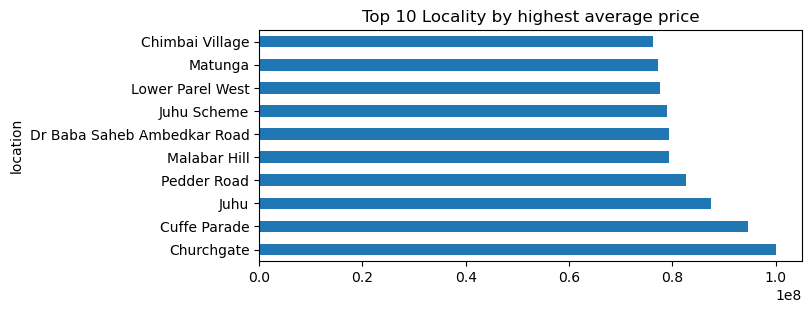

In [139]:
df.groupby('location')['price'].mean().astype('int').reset_index().sort_values(by='price',ascending=False).head(10) \
 .plot(kind='barh',x='location',y='price',figsize=(7,3),title="Top 10 Locality by highest average price",legend=False,)

<Axes: title={'center': 'Top 10 Locality by Lowest average price'}, ylabel='location'>

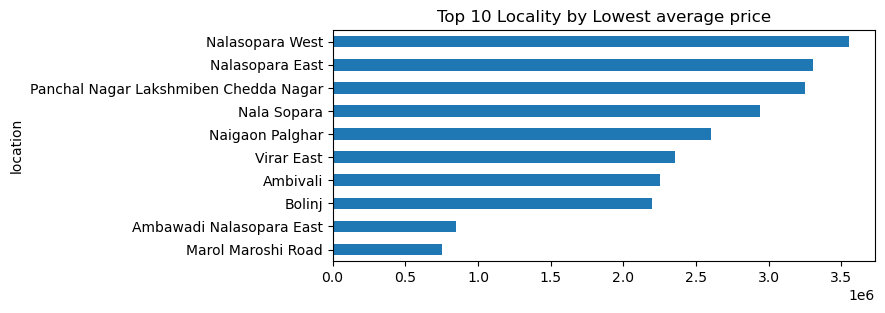

In [140]:
df.groupby('location')['price'].mean().astype('int').reset_index().sort_values(by='price',ascending=True).head(10) \
 .plot(kind='barh',x='location',y='price',figsize=(7,3),title="Top 10 Locality by Lowest average price",legend=False)

<Axes: title={'center': "Highest No of flat listing's per location"}, ylabel='location'>

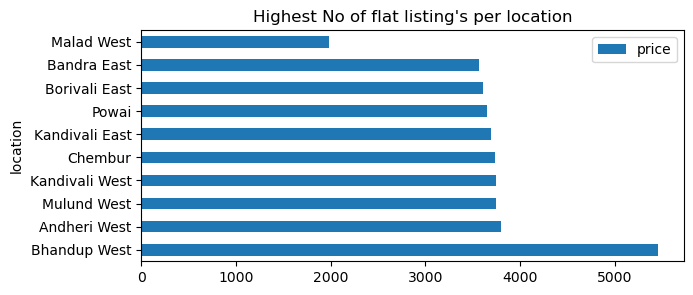

In [141]:
df.groupby('location')['price'].count().reset_index().sort_values(by='price',ascending=False).head(10) \
.plot(kind='barh',x='location',y='price',figsize=(7,3),title="Highest No of flat listing's per location")

### Visualizing Co-relation Matrix

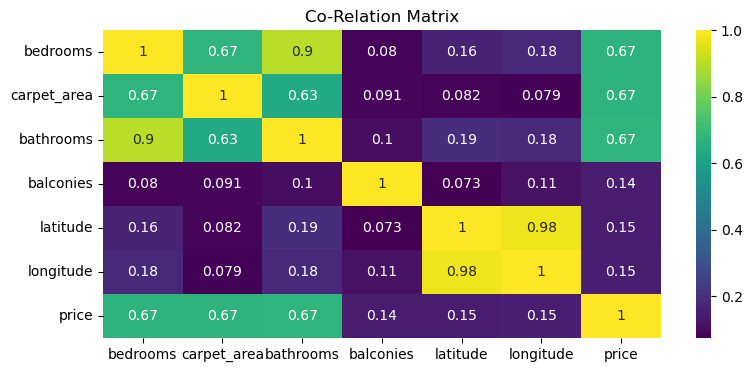

In [142]:
cm  = df[numeric_cols].corr()

plt.figure(figsize=(9,4))
plt.title("Co-Relation Matrix")
sns.heatmap(cm,annot=True,cmap='viridis')
plt.show()

### Co-relation of categorical columns (Annova F-Test):

In [143]:
from scipy.stats import f_oneway

categorical_cols = ['location', 'property_type', 'poss_status', 'furnish_status']

for col in categorical_cols:
    groups = [df[df[col] == value]['price'] for value in df[col].unique()]
    
    f_stat, p_value = f_oneway(*groups)
    
    print(f"ANOVA for {col}:")
    print(f"  F-statistic: {f_stat:.2f}, P-value: {p_value:.5f}\n")


ANOVA for location:
  F-statistic: 494.27, P-value: 0.00000

ANOVA for property_type:
  F-statistic: 3131.80, P-value: 0.00000

ANOVA for poss_status:
  F-statistic: 3915.80, P-value: 0.00000

ANOVA for furnish_status:
  F-statistic: 2114.37, P-value: 0.00000



## Feature Engineering and Encoding:

In [144]:
df.columns

Index(['property_type', 'furnish_status', 'bedrooms', 'carpet_area',
       'bathrooms', 'balconies', 'poss_status', 'location', 'latitude',
       'longitude', 'price', 'log_carpet_area', 'log_price'],
      dtype='object')

#### Removing columns which dont affect target(price):

In [145]:
df = df.drop(columns=['latitude', 'longitude', 'log_carpet_area', 'log_price'], axis=1)
df.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,price
0,New Property,Unfurnished,2,761,2,2,Under Construction,Kandivali West,21800000
1,New Property,Unfurnished,2,684,2,0,Under Construction,Sion,21400000
2,New Property,Semi-Furnished,1,440,2,0,Under Construction,Navghar Road,8156093


#### Encoding property_type , furnish_staus,poss_status columns:

In [146]:
print(df['property_type'].unique())
print(df['furnish_status'].unique())
print(df['poss_status'].unique())

['New Property' 'Resale']
['Unfurnished' 'Semi-Furnished' 'Furnished']
['Under Construction' 'Ready to Move']


In [147]:
df_encoded = df

df_encoded['property_type'] = df['property_type'].map({'Resale':0 , 'New Property':1})
df_encoded['furnish_status'] = df['furnish_status'].map({'Unfurnished':0, 'Semi-Furnished':1, 'Furnished':2})
df_encoded['poss_status'] = df['poss_status'].map({'Under Construction':0 , 'Ready to Move':1})

df_encoded.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,price
0,1,0,2,761,2,2,0,Kandivali West,21800000
1,1,0,2,684,2,0,0,Sion,21400000
2,1,1,1,440,2,0,0,Navghar Road,8156093


### Encoding location using Target encoding.

In [148]:
avg_price_location = df_encoded.groupby('location')['price'].mean().astype('int')

df_encoded['location_encoded'] = df_encoded['location'].map(avg_price_location)
df_encoded.drop('location',axis=1,inplace=True)
df_encoded.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,price,location_encoded
0,1,0,2,761,2,2,0,21800000,24084079
1,1,0,2,684,2,0,0,21400000,33022595
2,1,1,1,440,2,0,0,8156093,9233415


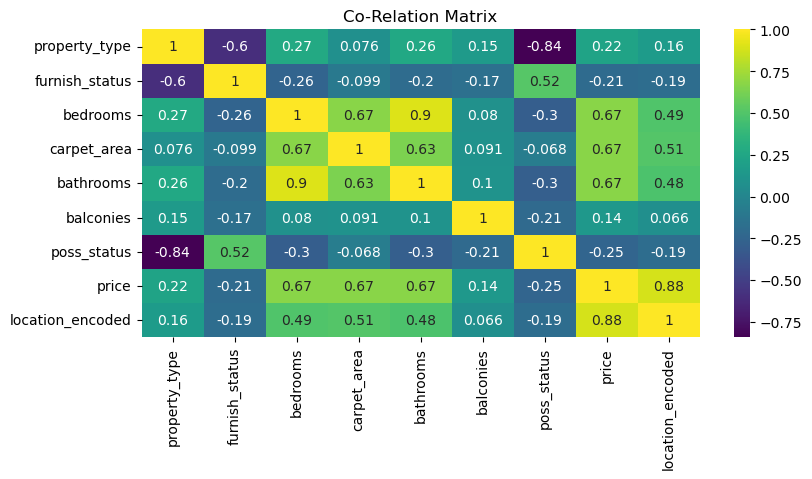

In [149]:
numeric_cols = df_encoded.select_dtypes(exclude=['object']).columns

cm = df[numeric_cols].corr()
plt.figure(figsize=(9,4))
plt.title("Co-Relation Matrix")
sns.heatmap(cm,annot=True,cmap='viridis')
plt.show()

## Model Training:

In [150]:
X = df_encoded.drop('price',axis=1)
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

print(df.shape)
print("X_train and X_test", X_train.shape,X_test.shape)
print("y_train and y_test" ,y_train.shape,y_test.shape)

(59164, 9)
X_train and X_test (41414, 8) (17750, 8)
y_train and y_test (41414,) (17750,)


In [151]:
# Lets create a custom function for model training and calculating the metrics:

def calculate(model):
     model.fit(X_train,y_train)
     y_pred = model.predict(X_test)
     
     train_score = model.score(X_train,y_train)
     test_score = model.score(X_test,y_test)
     mse = mean_squared_error(y_test,y_pred)
     rmse = np.sqrt(mse)
     r2 = r2_score(y_test,y_pred)

     print( f"Model => {model} ")
     
     print(f"train score = {round(train_score,2)}")
     print(f"test score = {round(test_score,2)}")
     print(f"Rmse = {round(rmse,2)}" )
     print(f"r2 score = {round(r2,2)}")
     

In [152]:
calculate(LinearRegression())

Model => LinearRegression() 
train score = 0.87
test score = 0.89
Rmse = 6220252.41
r2 score = 0.89


In [153]:
calculate(Ridge())

Model => Ridge() 
train score = 0.87
test score = 0.89
Rmse = 6220241.08
r2 score = 0.89


In [154]:
calculate(RandomForestRegressor())

Model => RandomForestRegressor() 
train score = 1.0
test score = 0.98
Rmse = 2757892.88
r2 score = 0.98


In [155]:
calculate(XGBRegressor())

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 0.99
test score = 0.97
Rmse = 3221320.84
r2 score = 0.97


## Model Fine Tuning:

In [ ]:
rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'bootstrap': False
}

calculate(RandomForestRegressor(**rf_params,random_state=42))

In [ ]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 3,
    'reg_alpha': 1,
    'reg_lambda': 5,
}

calculate(XGBRegressor(**xgb_params))

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 0.99
test score = 0.97
Rmse = 2955707.53
r2 score = 0.97


## Error margin:

In [162]:
X_train.columns

Index(['property_type', 'furnish_status', 'bedrooms', 'carpet_area',
       'bathrooms', 'balconies', 'poss_status', 'location_encoded'],
      dtype='object')

In [163]:
best_model = XGBRegressor(**xgb_params1)
best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct =  residuals *100 / y_test

results_df = pd.DataFrame(
    {'Actual_value': y_test,
    'predicted_value': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
    }
)

results_df.head(3)

,Actual_value,predicted_value,diff,diff_pct
31115,36800000,36697472.0,-102528.0,-0.278609
2749,16900000,17881692.0,981692.0,5.808828
43627,27586000,27585664.0,-336.0,-0.001218


### Feature Importance:

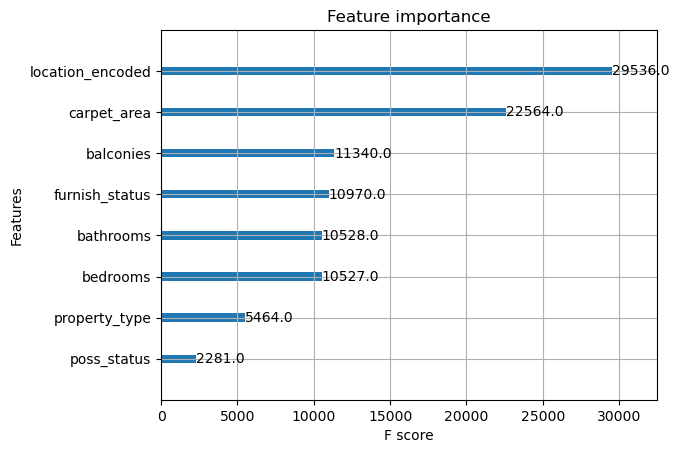

In [164]:
from xgboost import plot_importance
plot_importance(best_model)
plt.show()

In [165]:
np.abs(results_df['diff_pct']).describe()

count       17750.0
mean        3.87831
std       23.983174
min        0.000323
25%         0.06337
50%        0.155508
75%        0.278609
max      954.015111
Name: diff_pct, dtype: Float64

In [166]:
results_df[np.abs(results_df['diff_pct']) > 10].shape

(1378, 4)

In [167]:
extreme_error_threshold = 10  # Threshold of 10% to calculate errors more than 10%.
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
print(extreme_results_df.shape)
extreme_results_df.head()

(1378, 4)


,Actual_value,predicted_value,diff,diff_pct
4765,12000000,14141064.0,2141064.0,17.8422
3638,16000000,28816100.0,12816100.0,80.100625
5031,13500000,11128201.0,-2371799.0,-17.568881
114,46000000,27183684.0,-18816316.0,-40.905035
309,25000000,11227358.0,-13772642.0,-55.090568


In [168]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

7.763380281690141

#### For Error margin of more than 10% we have 1378 rows.

#### This means for 7.76% of flats we will predict the price by more or less than 10%

### Sample predictions:

In [180]:
df_encoded.head(1)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,price,location_encoded
0,1,0,2,761,2,2,0,21800000,24084079


In [181]:
test_sample = {
    "property_type": 1,         # Example: 1 for resale, 0 for new
    "furnish_status": 0,        # Example: 0 = Unfurnished, 1 = Semi-furnished, 2 = Fully-furnished
    "bedrooms": 2,              # Example: 2 BHK
    "carpet_area": 761,         # Example: 850 sq. ft.
    "bathrooms": 2,             # Example: 2 bathrooms
    "balconies": 2,             # Example: 2 balconies
    "poss_status": 0,           # Example: 1 = Ready to move, 0 = Under construction
    "location_encoded": 24084079     # Encoded value for location
}

test_df = pd.DataFrame([test_sample])
predicted_price = best_model.predict(test_df)
print(predicted_price)

[22042598.]
